Perceptual decision making task

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Task

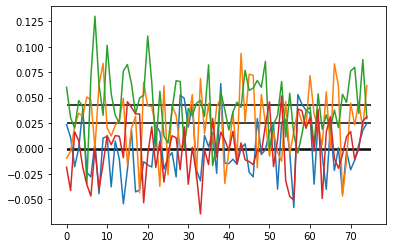

In [2]:
dt = 20 # integration timestep, ms
N = 512 # neurons
batch_size = 32
time_steps = int((100 + 800 + 300 + 300) / dt)
inputs = np.random.normal(size=(batch_size, time_steps), scale = 0.03)
I = np.random.normal(size=(N, )) # input direction, fixed. 
u = np.random.choice(2**np.arange(0, 5), size=(batch_size, 1)) * 3.2 / 1000
inputs += u
plt.plot(inputs[:4].T)
plt.hlines(inputs[:4].mean(1), 0, time_steps)

In [3]:
def make_input(I, batch_size = 32, dt = 20):
    """ I: input pattern of size (neurons, )"""
    time_steps = int((100 + 800 + 300 + 300) / dt)
    inputs = np.random.normal(size=(batch_size, time_steps), scale = 0.03)
    u_set = np.unique(np.array([-1, 1])[:,None] * 2**np.arange(0, 5)[None])
    u = np.random.choice(u_set, size=(batch_size, 1)) * 3.2 / 100
    inputs[:,int(100/dt):int(900/dt)] += u
    # Outputs
    outputs = np.sign(u) * np.ones((1, int(300 / dt))) #batch size * decision period
    return inputs, outputs

In [4]:
neurons = 512
I = np.random.normal(size=(neurons, ))
x, y = make_input(I)
dtype = torch.float

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


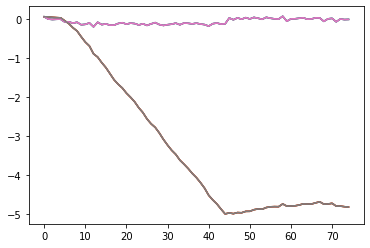

In [5]:
for i in range(4):
    plt.plot(x[0].T)
    print(y[0])
    plt.plot(x[0].cumsum())

In [6]:
class RNN(torch.nn.Module):
  def __init__(self, I, w):
    """
    I: input pattern, size (N, )
    w: readout, size (N, )
    R: rank, int. 
    """
    super(RNN, self).__init__()
    self.N = I.shape[0]
    self.I = torch.tensor(I, dtype=dtype)
    self.w = torch.tensor(w, dtype=dtype)
    self.m = torch.nn.Parameter(torch.normal(mean=0, std=1, size=(N, )))
    self.n = torch.nn.Parameter(torch.normal(mean=0, std=1, size=(N, )))
    #self.J = torch.nn.Parameter(torch.normal(mean=0, std=1/np.sqrt(N), size=(N,N )))
    
  def forward(self, inputs):
    """
    inputs: tensor of size (batch size, time_steps, neurons)
    """
    inputs = torch.tensor(inputs, dtype=dtype)
    batch_size, time_steps = inputs.shape
    N = self.N
    x = torch.zeros((batch_size, N))
    x_rec = [] 
    phi = torch.tanh
    dt = 20 # ms
    tau = 100
    J = torch.mm(self.m[:,None], self.n[None]) / N # self.J
    noise = torch.normal(mean=0, std=0.05, size=(batch_size, time_steps, N))
    I = torch.einsum("abc,cd->abd", inputs[:,:,None], self.I[None]) #(batch_size, time_steps, 1) *(1, neurons)
    #print(I.shape)
     
    for t in range(time_steps):
        dxdt = -x + torch.mm(phi(x), J.T) + inputs[:,t][:,None] * self.I[None] +  noise[:,t]
        x = x + dt / tau * dxdt 
        x_rec.append(x)
    x_rec = torch.stack(x_rec, 1)
    z = torch.einsum("abc,c->ab", phi(x_rec), self.w) / N 
    return x_rec, z

In [7]:
I = np.random.normal(size=(neurons, ))
w = np.random.normal(size=(neurons, ), scale=4)
inputs, outputs = make_input(I)
rnn = RNN(I, w)
with torch.no_grad():
    x, z = rnn(inputs) 

## Train

0 1.0001047849655151
20 0.9990270137786865
40 0.9844798445701599
60 0.7817803621292114
80 0.011015127412974834
100 0.0018079037545248866
120 0.0015274760080501437
140 0.0006396397948265076
160 0.00027383692213334143
180 0.00024396365915890783


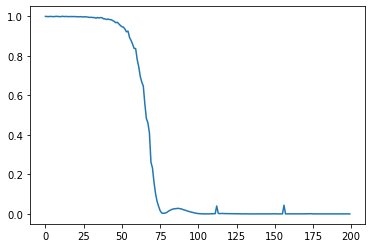

In [8]:
# New patterns and RNN:
I = np.random.normal(size=(neurons, ))
w = np.random.normal(size=(neurons, ), scale=4)
rnn = RNN(I, w)
# Optimization:
optim = torch.optim.Adam(rnn.parameters(), lr=1e-2)
loss_fn = torch.nn.MSELoss()
loss_hist = []
steps = 200

for step in range(steps):
    #if step==0: 
    inputs, outputs = make_input(I, batch_size=64)
    x, z = rnn(inputs)
    loss = loss_fn(z[:,-15:], torch.tensor(outputs, dtype=dtype))
    optim.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), 1.0)
    optim.step()
    if step%20 == 0: print(step, loss.item())
    loss_hist.append(loss.item())
plt.plot(loss_hist)

In [9]:
with torch.no_grad():
    x, z = rnn(inputs)

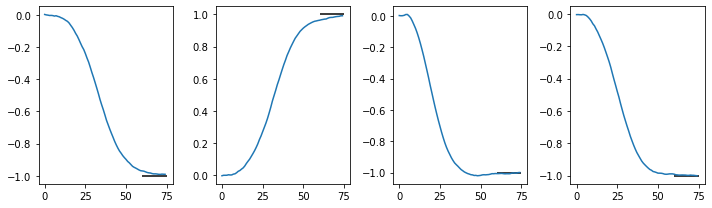

In [10]:
f, ax = plt.subplots(1, 4, sharex=True, figsize=(10, 3))
for i in range(4):
    ax[i].plot(z[i].T)
    ax[i].hlines(outputs[i,0], 60, 75)
    ax[i]
    #ax[i].set_title(np.sign(outputs[i,0]) == np.sign(z[i,-1]))
plt.tight_layout()

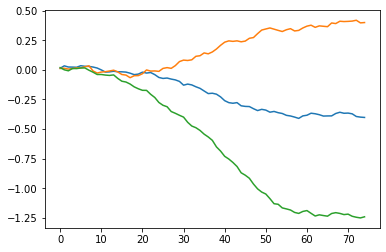

In [11]:
plt.plot(x[0,:,:3])

In [12]:
m = rnn.m.detach().numpy()
n = rnn.n.detach().numpy()
np.cov(m, w)[0,1], np.cov(n, w)[0,1], np.cov(m, n)[0,1], np.cov(m, w)[0,1], np.cov(n, w)[0,1], np.cov(n, I)[0,1]

(2.2004226376360356,
 0.9186023403504538,
 1.4639827072090361,
 2.2004226376360356,
 0.9186023403504538,
 0.5364617350070372)

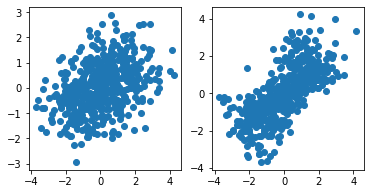

In [13]:
f, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].scatter(n, I)
ax[1].scatter(m, n)

Test performance

In [14]:
def make_input(I, batch_size = 32, dt = 20, u_set = None):
    """ I: input pattern of size (neurons, )"""
    time_steps = int((100 + 800 + 300 + 300) / dt)
    inputs = np.random.normal(size=(batch_size, time_steps), scale = 0.03)
    if u_set is None:
        u_set = np.unique(np.array([-1, 1])[:,None] * 2**np.arange(0, 5)[None])
    u = np.random.choice(u_set, size=(batch_size, 1)) * 3.2 / 100
    inputs[:,int(100/dt):int(900/dt)] += u
    # Outputs
    outputs = np.sign(u) * np.ones((1, int(300 / dt))) #batch size * decision period
    return inputs, outputs

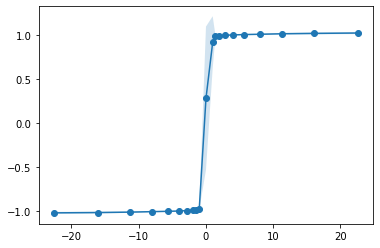

In [15]:
outs = []
outs_std = []
us = list(np.unique(np.array([-1, 1])[:,None] * 2**np.arange(0, 5, 0.5)[None]))
us.append(0)
us = np.sort(us)
for u in us:
    inputs, outputs = make_input(I, u_set = [u])
    with torch.no_grad():
        x, z = rnn(inputs)
    outs.append(z[:,-15:].mean())
    outs_std.append(z[:,-15:].std())
outs = np.array(outs)
outs_std = np.array(outs_std)
plt.plot(us, outs, 'o-')
plt.fill_between(us, outs - outs_std, outs + outs_std, alpha=0.2)

Next step: Resample.
1. Fit cluster in (m,n) space (no: input, output, connectivity)
2. Sample from covariance

In [16]:
X = np.zeros((N, 4))
X[:,0] = m
X[:,1] = n
X[:,2] = rnn.I
X[:,3] = rnn.w
C = np.cov(X.T)#- X.mean(0,keepdims=True).T)
print(np.diag(C))

[ 2.0443127   2.10423209  0.93491205 15.97496381]


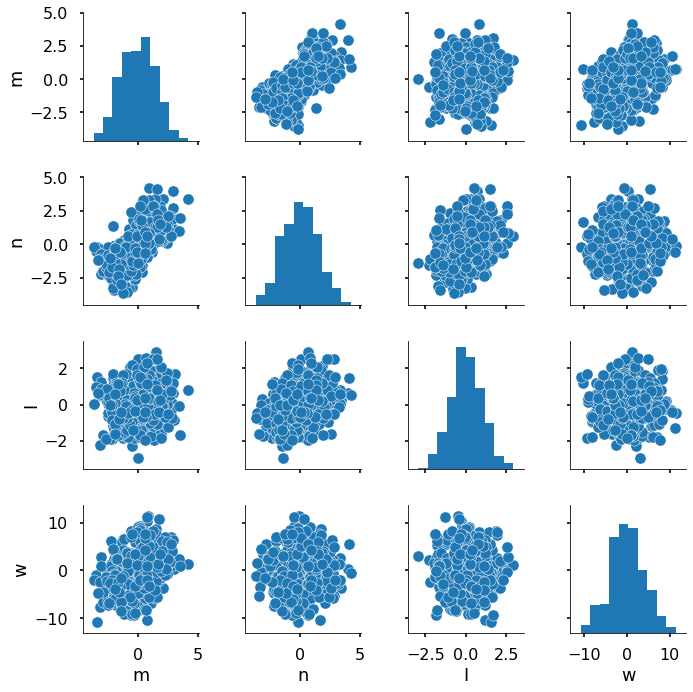

In [17]:
import pandas as pd
df = pd.DataFrame(data=X, columns=['m','n','I', 'w'])
import seaborn as sns
sns.set_context("poster")
sns.pairplot(df)

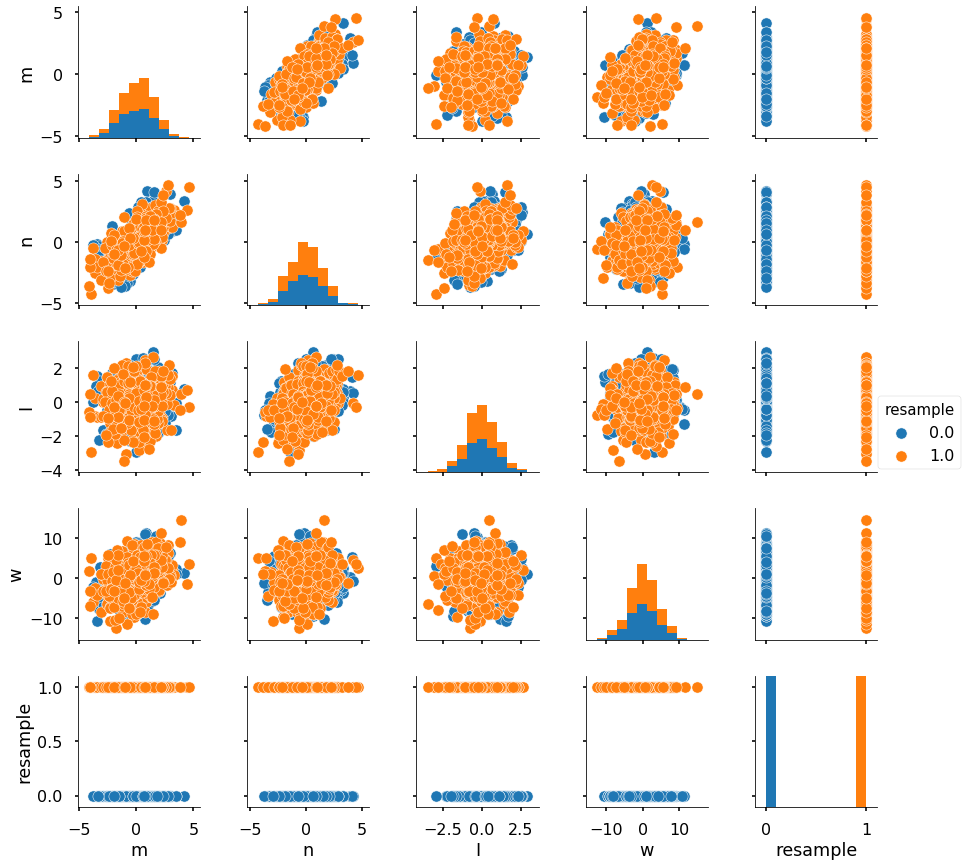

In [19]:
C = np.cov(X.T)
X_new = np.random.multivariate_normal(np.zeros((4, )), C, size=(N, ))
Y = np.zeros((N*2,5 ))
Y[:N,:-1] = X
Y[N:,:-1] = X_new
Y[N:,-1] = 1

df = pd.DataFrame(data=Y, columns=['m','n','I', 'w', 'resample'])
import seaborn as sns
sns.set_context("poster")
sns.pairplot(df, hue='resample')

In [ ]:
inputs, outputs = make_input(I)# u_set = [u])
with torch.no_grad():
    x, z = rnn_resample(inputs)
f, ax = plt.subplots(1, 5, sharex=True, figsize=(10, 3))
for i in range(5):
    j = np.random.randint(32)
    ax[i].plot(z[j].T)
    ax[i].hlines(outputs[j,0], 60, 75)
    #ax[i].set_title(np.sign(outputs[i,0]) == np.sign(z[i,-1]))
plt.tight_layout()